In [1]:
#Load Libraries
import numpy as np            
import pandas as pd           
import matplotlib.pyplot as plt  
import scipy                  
import filterpy
import utm 
from pykalman import KalmanFilter

%matplotlib inline

## Define Functions

In [2]:
# Read data and transform GPS data from Long/Lat to X/Y 
def read_data():
    accel_data = pd.read_csv('.//2023-11-17-15-11-06//accel-0.csv')
    gps_time_data = pd.read_csv('.//2023-11-17-15-11-06//gps_time.csv')
    gps_visibility_data = pd.read_csv('.//2023-11-17-15-11-06//gps_visibility.csv')
    gps_data = pd.read_csv('.//2023-11-17-15-11-06//ref_gps.csv')
    gyro_data = pd.read_csv('.//2023-11-17-15-11-06//gyro-0.csv')
    mag_data = pd.read_csv('.//2023-11-17-15-11-06//mag-0.csv')
    time_data = pd.read_csv('.//2023-11-17-15-11-06//time.csv')

    # Determine the UTM zone of the first point
    first_point = utm.from_latlon(gps_data.iloc[0]['ref_gps_lat (deg)'], gps_data.iloc[0]['ref_gps_lon (deg)'])
    target_zone_number = first_point[2]
    target_zone_letter = first_point[3]

    # Convert all GPS data to the target UTM zone
    utm_coords = gps_data.apply(
        lambda row: utm.from_latlon(
            row['ref_gps_lat (deg)'],
            row['ref_gps_lon (deg)'],
            force_zone_number=target_zone_number,
            force_zone_letter=target_zone_letter
        ),
        axis=1
    )
    utm_df = pd.DataFrame(
        utm_coords.tolist(),
        columns=['east', 'north', 'zone_number', 'zone_letter']
    )
    
    # Set the first UTM coordinate as the origin
    origin_x, origin_y = utm_df.iloc[0]['east'], utm_df.iloc[0]['north']
    
    # Subtract origin to convert UTM coordinates to position-based data
    gps_data['pos_x'] = utm_df['east'] - origin_x
    gps_data['pos_y'] = utm_df['north'] - origin_y

    
    return accel_data, gps_time_data, gps_visibility_data, gps_data, gyro_data, mag_data, time_data

In [3]:
#Calculate Orientation

def calculate_orientation(a_x, a_y, a_z, previous_pitch, previous_roll):
    
    alpha = 0.9999
    
    theta_z = np.arctan2(a_y, a_z)
    theta_x = np.arctan2(a_x, np.sqrt(a_y**2 + a_z**2))
    pitch = (previous_pitch * alpha) + (theta_x * (1 - alpha))
    roll = (previous_roll * alpha) + (theta_z * (1 - alpha))
    
    return pitch, roll

In [4]:
#Calculate Velocity

def calculate_velocity(a_x, a_y, a_z, previous_velocity_x, previous_velocity_y, previous_velocity_z, delta_t):
    
    velocity_x = previous_velocity_x + a_x * delta_t
    velocity_y = previous_velocity_y + a_y * delta_t
    velocity_z = previous_velocity_z + a_z * delta_t
    
    return velocity_x, velocity_y, velocity_z

In [5]:
#Calculate Position

def calculate_position(previous_position_x, previous_position_y, velocity_x, velocity_y, delta_t):
    
    position_x = previous_position_x + velocity_x * delta_t
    position_y = previous_position_y + velocity_y * delta_t

    return position_x, position_y

In [6]:
# Create Rotation Matrix

def create_rotation_matrix(yaw):

    c, s = np.cos(yaw), np.sin(yaw)
    R = np.array([[-c, -s], [-s, c]])  
    
    return R

In [7]:
# Apply Kalman Filter to Data 

def run_kalman_filter(data_in, dt, var):
    # Initialize Kalman Filter parameters
    F = np.array([[1, dt, 0.5 * dt**2], [0, 1, dt], [0, 0, 1]])
    H = np.array([0, 0, 1])
    Q = np.array([[0.2, 0, 0], [0, 0.1, 0], [0, 0, 10e-4]])
    R = np.array([[var]])
    X0 = np.array([0, 0, data_in[0]])
    P0 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, var]])

    # Define the Kalman Filter
    kf = KalmanFilter(transition_matrices=F, observation_matrices=H, transition_covariance=Q, 
                      observation_covariance=R, initial_state_mean=X0, initial_state_covariance=P0)

    # Iterative estimation for each new measurement
    filtered_state_means = np.zeros((len(data_in), 3))
    for t in range(len(data_in)):
        if t == 0:
            filtered_state_means[t] = X0
        else:
            filtered_state_means[t], _ = kf.filter_update(
                filtered_state_means[t-1],
                P0,
                observation=data_in[t]
            )

    return filtered_state_means[:, 2]


In [8]:
# Rotate Acceleration data to be in NED frame, consistent with GPS orientation
def run_kalman_filter_with_transformation(accel_array, mag_data, dt, var):
    # Initialize arrays for filtered acceleration data
    filtered_accel_ned = np.zeros_like(accel_array)

    # Apply Kalman filter to each axis
    for i in range(3):  # For x, y, and z axes
        filtered_axis_data = run_kalman_filter(accel_array[:, i], dt, var)
        filtered_accel_ned[:, i] = filtered_axis_data

    # Transform acceleration data to NED frame
    for i in range(len(filtered_accel_ned)):
        yaw = calculate_yaw(mag_data['mag_x (uT)'].iloc[i], mag_data['mag_y (uT)'].iloc[i])
        R = create_rotation_matrix(yaw)

        # Apply rotation matrix to x and y components
        accel_body = filtered_accel_ned[i, :2]
        accel_ned = R @ accel_body
        filtered_accel_ned[i, :2] = accel_ned

    return filtered_accel_ned

In [9]:
# Calculate Yaw

def calculate_yaw(mag_x, mag_y):
    
    yaw = np.arctan2(mag_y, mag_x)
    
    return yaw

In [10]:
# Dead reckoning algorithm with GPS and DVL updates 

def calculate_position_with_gps_update(filtered_accel_ned, gps_data, imu_time, delta_t, f_gps, f_dvl):

    #Calculate update intervals based on f_gps and f_dvl
    total_samples = len(filtered_accel_ned)
    gps_update_interval = int(total_samples * (f_gps / 100)) 
    dvl_update_interval = int(total_samples * (f_dvl / 100))
    
    # Initialize variables
    prev_pos_x, prev_pos_y, prev_vel_x, prev_vel_y, prev_vel_z = 0, 0, 0, 0, 0
    positions_x, positions_y = [], []
    R = np.array([[0, 1], [-1, 0]])  # Rotation matrix
    R_gps = np.linalg.inv(R)  # Inverse rotation for GPS coordinates

    for i in range(total_samples):
        # Calculate velocity
        velocity_x = prev_vel_x + filtered_accel_ned[i, 0] * delta_t
        velocity_y = prev_vel_y + filtered_accel_ned[i, 1] * delta_t
        velocity_z = prev_vel_z + filtered_accel_ned[i, 2] * delta_t
        
        # Calculate position
        pos_x = prev_pos_x + velocity_x * delta_t
        pos_y = prev_pos_y + velocity_y * delta_t
        
        # Update previous values
        prev_pos_x, prev_pos_y = pos_x, pos_y
        prev_vel_x, prev_vel_y, prev_vel_z = velocity_x, velocity_y, velocity_z
        
        # Store positions
        positions_x.append(pos_x)
        positions_y.append(pos_y)

        # Check if a GPS update is available
        if i != 0 and i % gps_update_interval == 0:
            # Map the IMU index to the GPS data index
            gps_index = int((i / total_samples) * len(gps_data))
            gps_index = min(gps_index, len(gps_data) - 1) 

            # Get GPS update
            pos_x_gps = gps_data['pos_x'].iloc[gps_index]
            pos_y_gps = gps_data['pos_y'].iloc[gps_index]
            pos_x_gps, pos_y_gps = R_gps @ np.array([pos_x_gps, pos_y_gps])

            # Update the previous positions with the GPS data
            prev_pos_x, prev_pos_y = pos_x_gps, pos_y_gps
            
        # Check if DVL update is available
        if i != 0 and i % dvl_update_interval == 0:
            # Map the IMU index to the GPS data index
            dvl_index = int((i / total_samples) * len(gps_data))
            dvl_index = min(dvl_index, len(gps_data) - 1) 

            # Get GPS update
            dvl_x_gps = gps_data['ref_gps_vE (m/s)'].iloc[dvl_index]
            dvl_y_gps = gps_data['ref_gps_vN (m/s)'].iloc[dvl_index]
            dvl_x_gps, dvl_y_gps = R_gps @ np.array([dvl_x_gps, dvl_y_gps])

            # Update the previous velocities
            prev_vel_x, prev_vel_y = dvl_x_gps, dvl_y_gps

    # Convert positions to numpy arrays
    positions_x = np.array(positions_x)
    positions_y = np.array(positions_y)
    positions = np.vstack((positions_x, positions_y))
    positions_x, positions_y = R @ positions # Rotate 90 degrees to match GPS orientation

    return positions_x, positions_y



In [11]:
# Plot data 

def plot_data(imu_positions, gps_data, labels, f_gps, f_dvl):
    %matplotlib inline
    gps_update_descriptors = {
        100: "No GPS Update",
        50: "Midpoint GPS Update",
        25: "Infrequent GPS Updates",
        10: "Frequent GPS Updates",
        5: "Very Frequent GPS Updates",
        1: "Near-Continuous GPS Updates"}

    dvl_update_descriptors = {
        100: "No DVL Update",
        50: "Midpoint DVL Update",
        25: "Infrequent DVL Updates",
        10: "Frequent DVL Updates",
        5: "Very Frequent DVL Updates",
        1: "Near-Continuous DVL Updates"}
        
    gps_description = gps_update_descriptors.get(f_gps, f"Updates Every {f_gps}% of Duration")
    dvl_description = dvl_update_descriptors.get(f_dvl, f"Updates Every {f_gps}% of Duration")
        
    # Convert GPS coordinates to UTM
    gps_x = gps_data['pos_x']
    gps_y = gps_data['pos_y']

    # Plot
    plt.figure(figsize=(16, 12))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(f'GPS vs. Estimated Position - {gps_description} - {dvl_description}')

    # Plot GPS path
    ax.plot(gps_x, gps_y, label='GPS Path', linestyle='-', color='black')

    # Plot IMU positions for each noise level
    for label, (x, y) in imu_positions.items():
        ax.plot(x, y, label=label)

    plt.legend()
    plt.show()

In [12]:
# Calculate Error

def calculate_rmse(imu_positions_x, imu_positions_y, imu_time, gps_data, gps_time):

    matched_imu_x = []
    matched_imu_y = []
    gps_x = gps_data['pos_x']
    gps_y = gps_data['pos_y']

    # Match IMU data to GPS timestamps
    for gps_t in gps_time:
        idx = (np.abs(imu_time - gps_t)).argmin()
        matched_imu_x.append(imu_positions_x[idx])
        matched_imu_y.append(imu_positions_y[idx])

    # Calculate RMSE
    squared_errors = [(x_imu - x_gps) ** 2 + (y_imu - y_gps) ** 2 for x_imu, y_imu, x_gps, y_gps in zip(matched_imu_x, matched_imu_y, gps_x, gps_y)]
    rmse = np.sqrt(np.mean(squared_errors))

    # Calculate cumulative distance and normalize RMSE
    cumulative_distance = np.sum(np.sqrt(np.diff(gps_x)**2 + np.diff(gps_y)**2))
    normalized_rmse = rmse / cumulative_distance if cumulative_distance != 0 else np.nan
    normalized_rmse = normalized_rmse*100

    rmse = round(rmse, 2)
    normalized_rmse = round(normalized_rmse, 2)

    return rmse, normalized_rmse


# Run Code

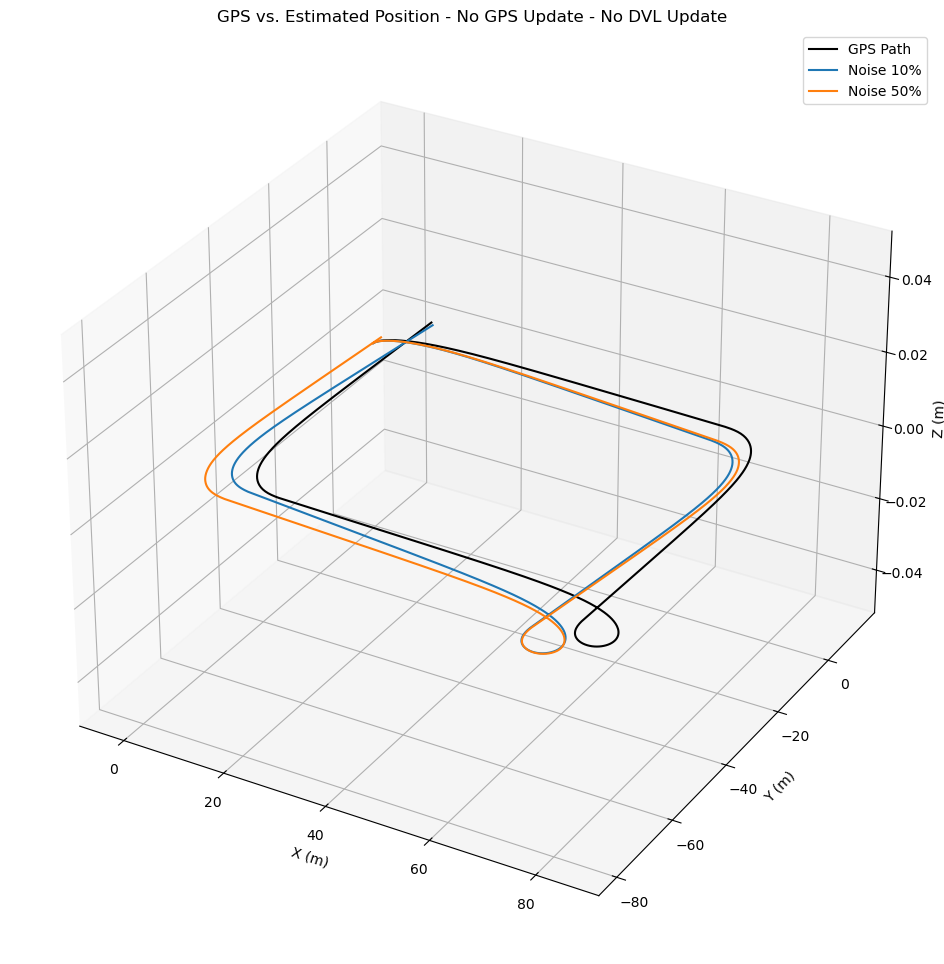

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   5.66   
1                                 50%                                   7.58   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.83   
1                                               2.45   


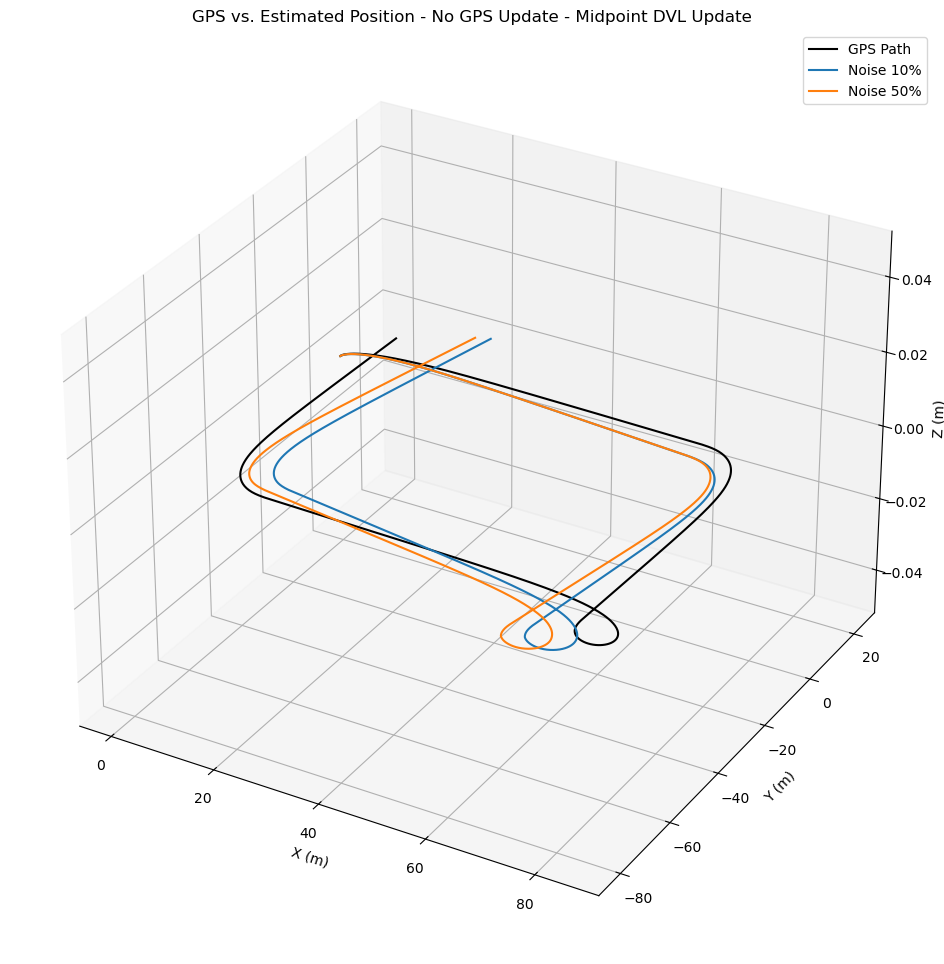

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   7.32   
1                                 50%                                   7.44   

   Average RMSE: Normalized per distance traveled (%)  
0                                               2.36   
1                                               2.40   


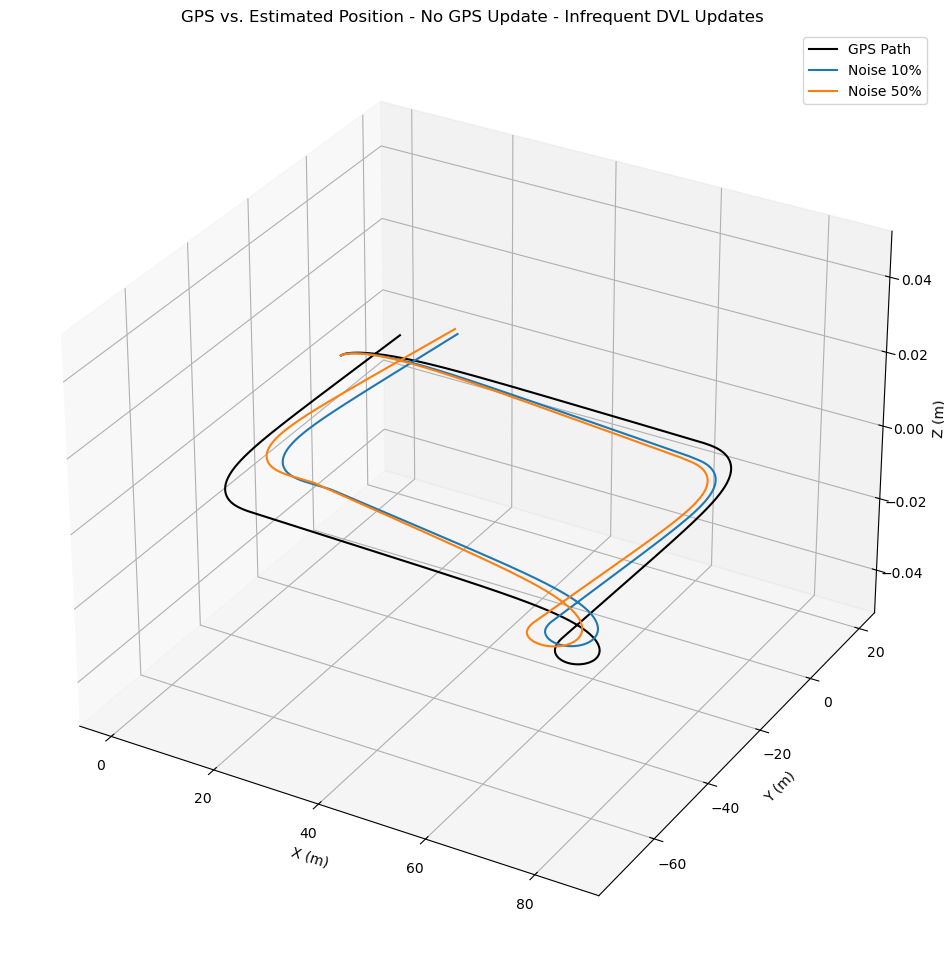

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   8.07   
1                                 50%                                   8.38   

   Average RMSE: Normalized per distance traveled (%)  
0                                               2.61   
1                                               2.71   


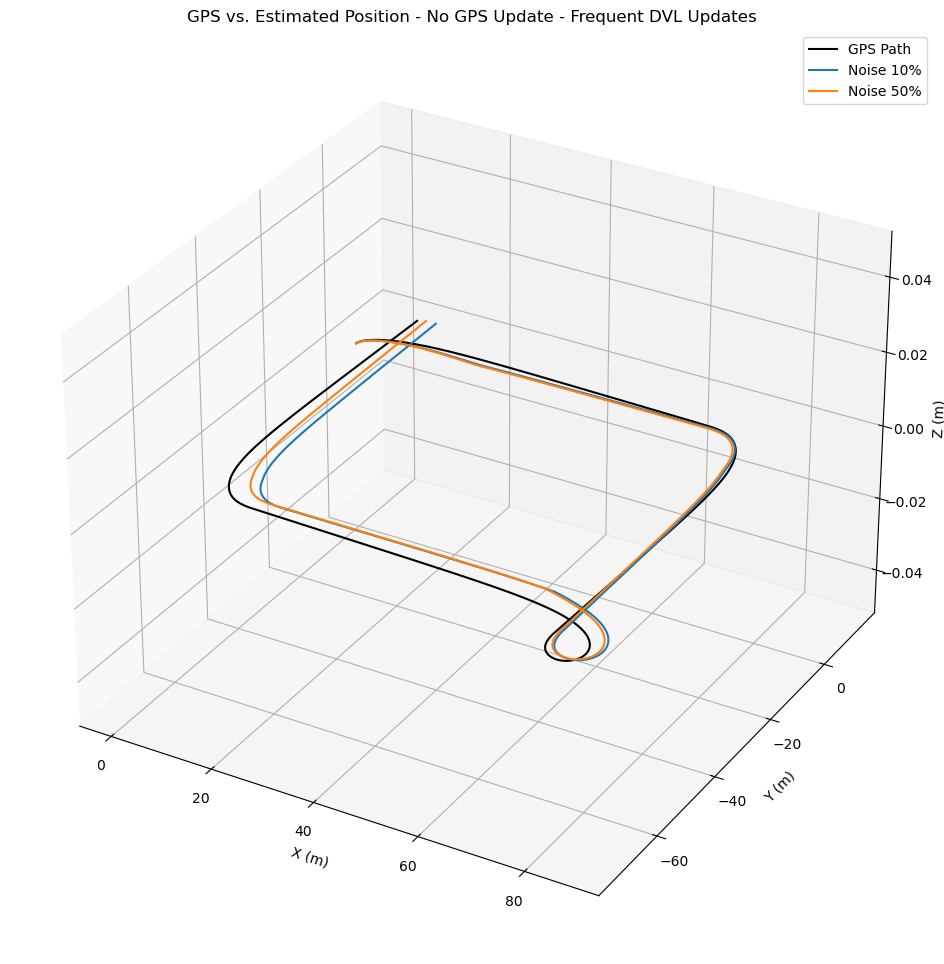

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   3.50   
1                                 50%                                   2.54   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.13   
1                                               0.82   


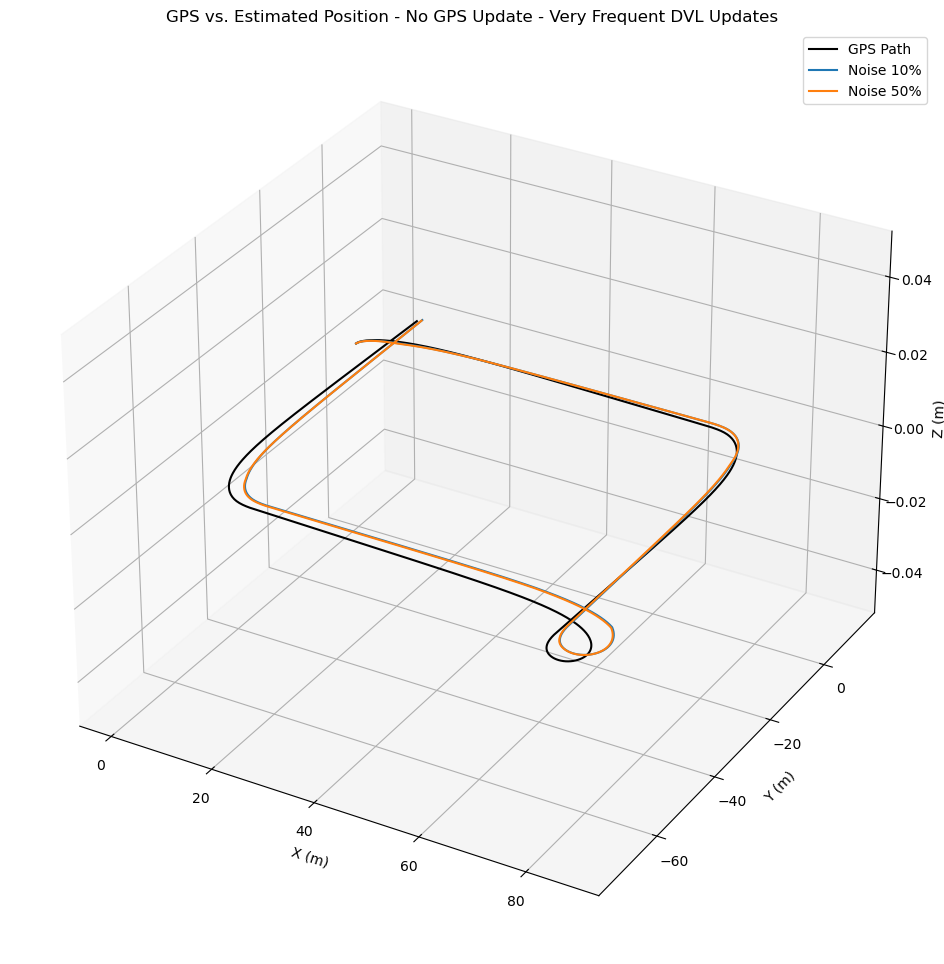

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.50   
1                                 50%                                   2.43   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.81   
1                                               0.78   


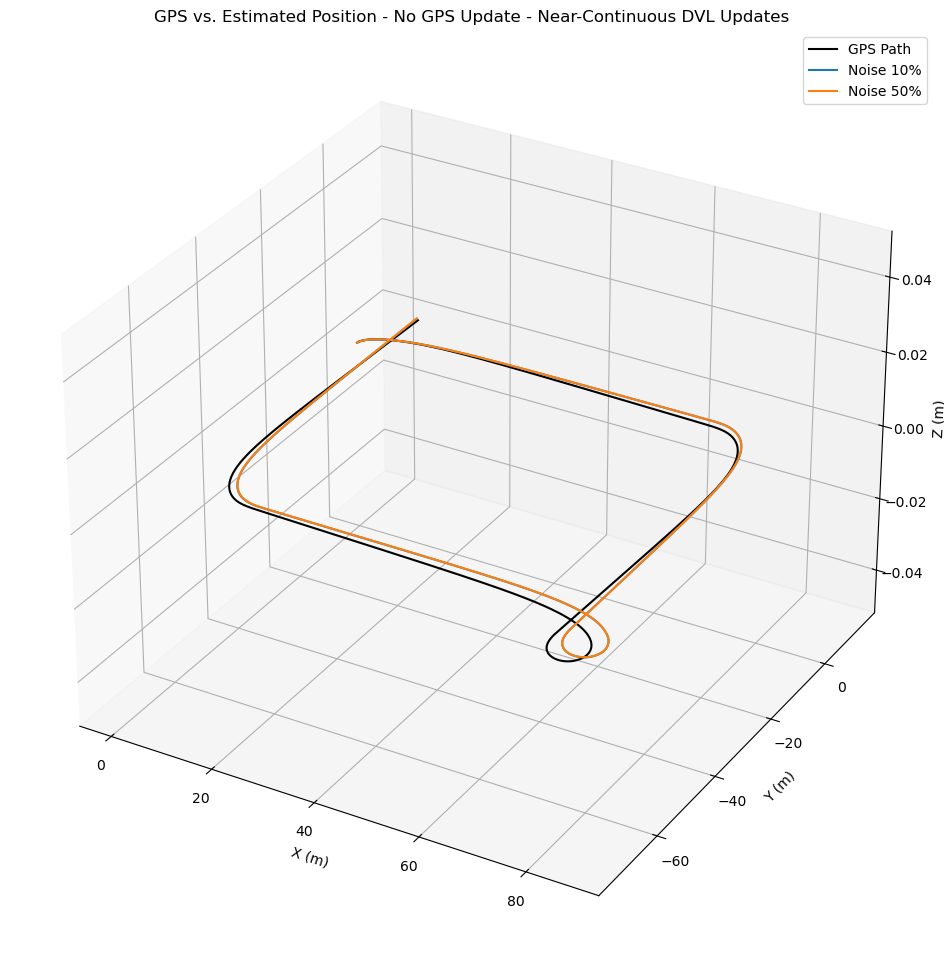

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.84   
1                                 50%                                   1.85   

   Average RMSE: Normalized per distance traveled (%)  
0                                                0.6   
1                                                0.6   


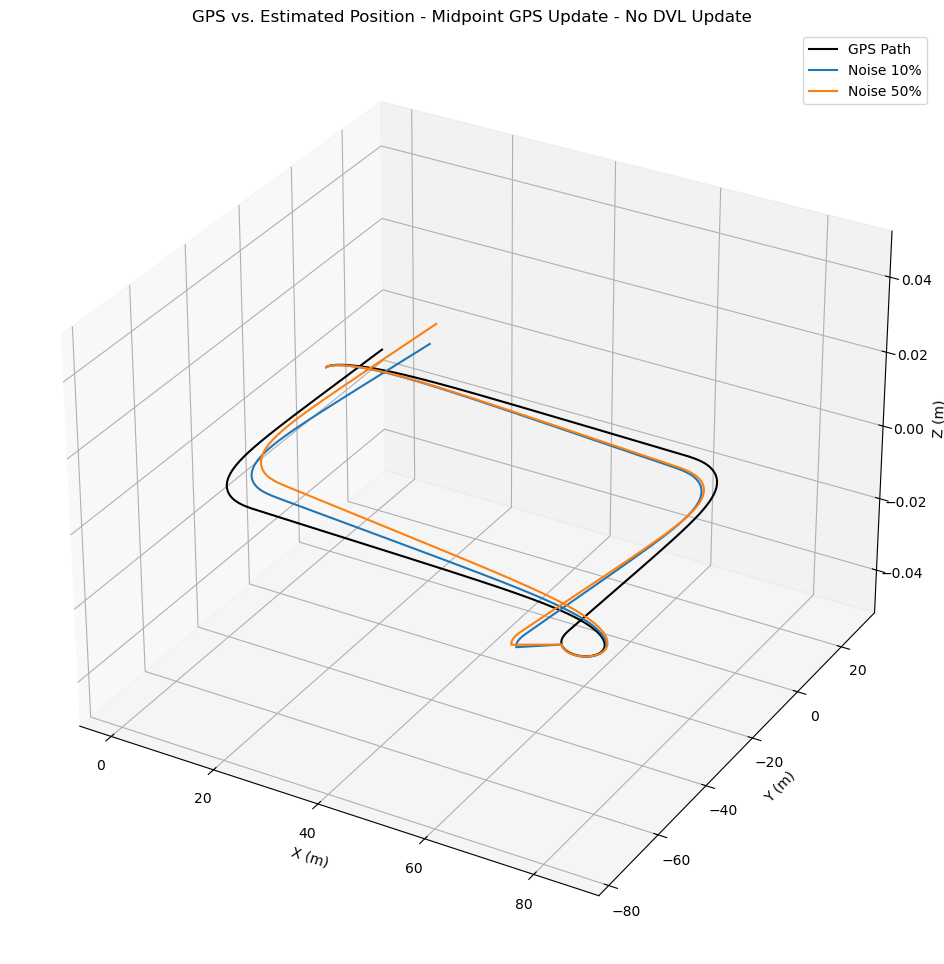

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   5.58   
1                                 50%                                   8.22   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.80   
1                                               2.65   


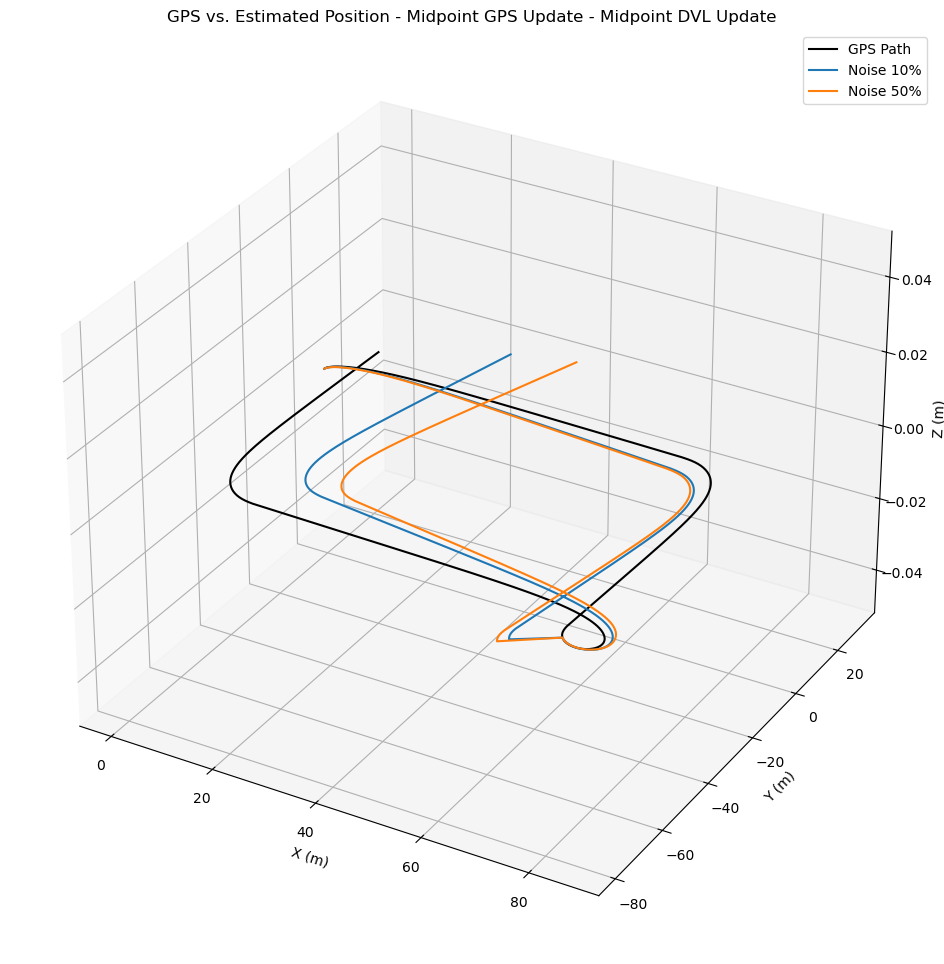

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                  10.67   
1                                 50%                                  15.15   

   Average RMSE: Normalized per distance traveled (%)  
0                                               3.44   
1                                               4.89   


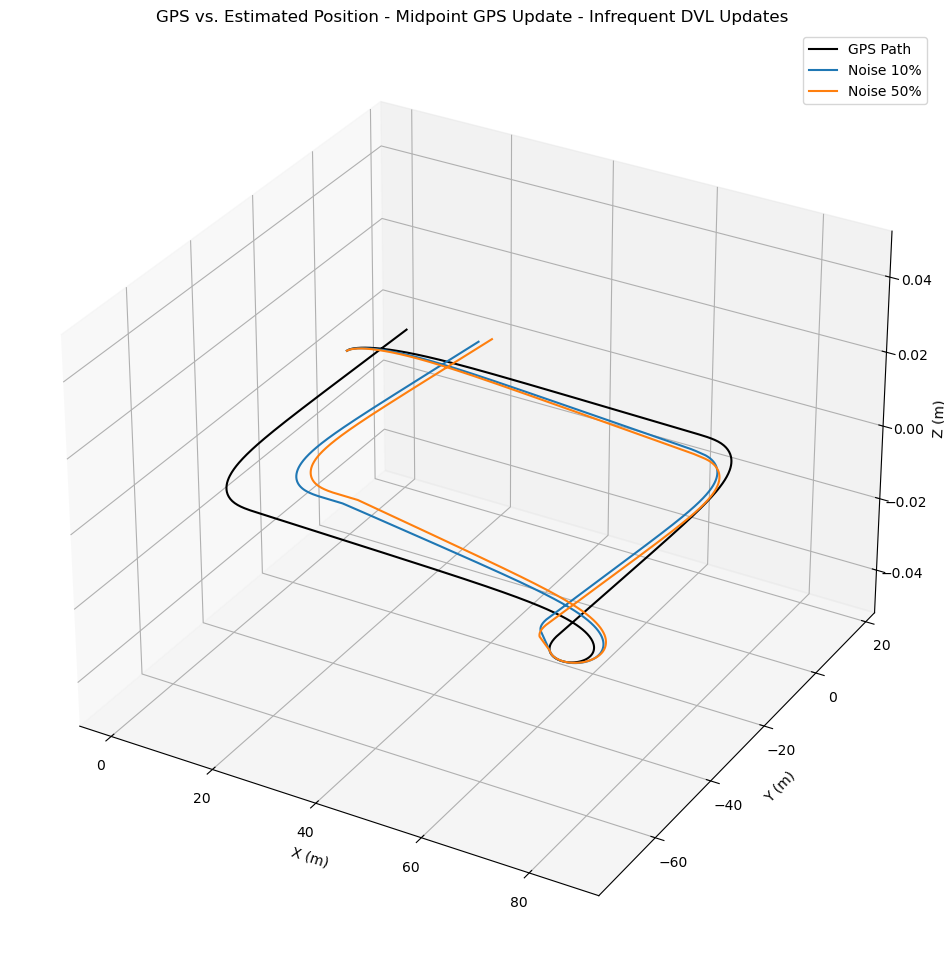

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   7.60   
1                                 50%                                   9.09   

   Average RMSE: Normalized per distance traveled (%)  
0                                               2.45   
1                                               2.94   


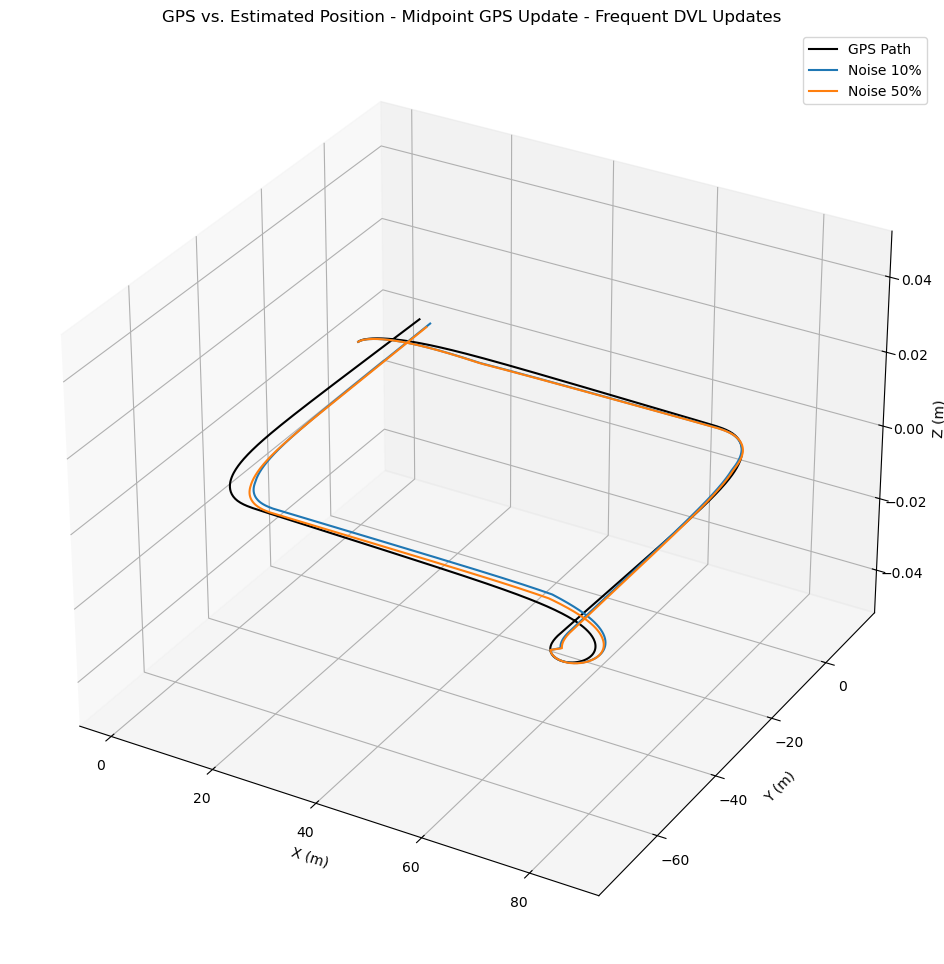

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.69   
1                                 50%                                   2.71   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.87   
1                                               0.88   


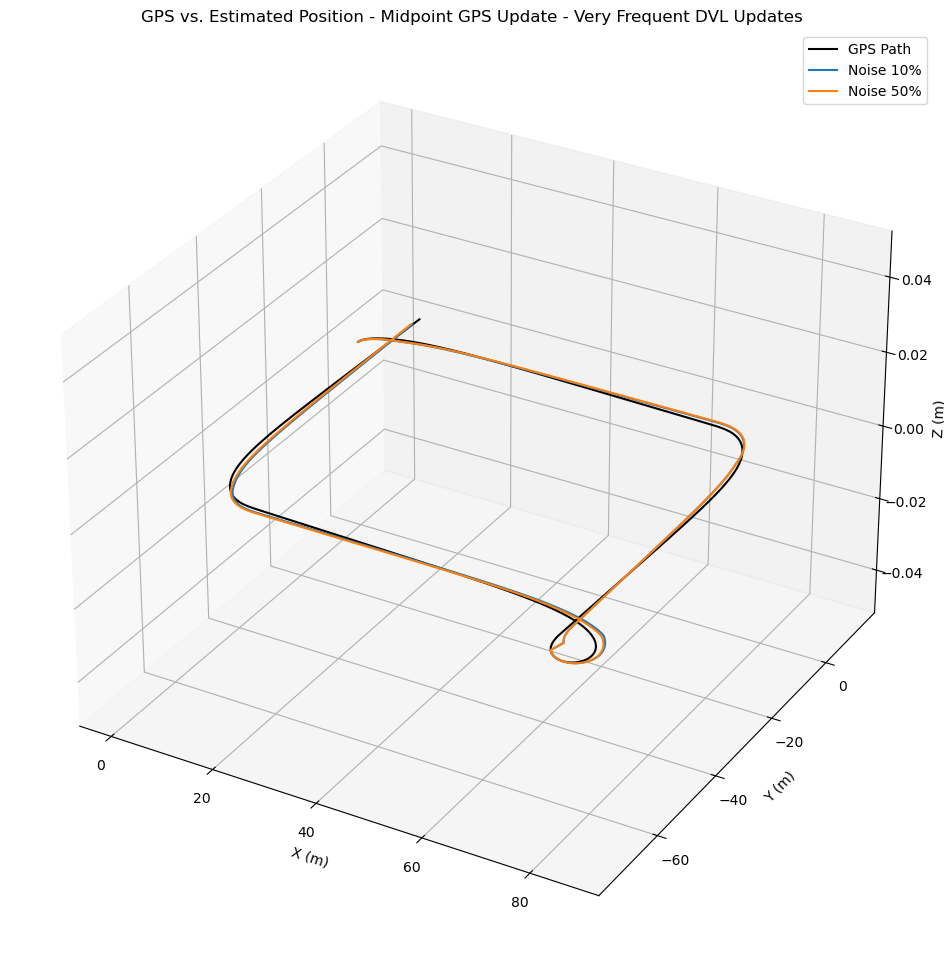

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.86   
1                                 50%                                   1.93   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.60   
1                                               0.62   


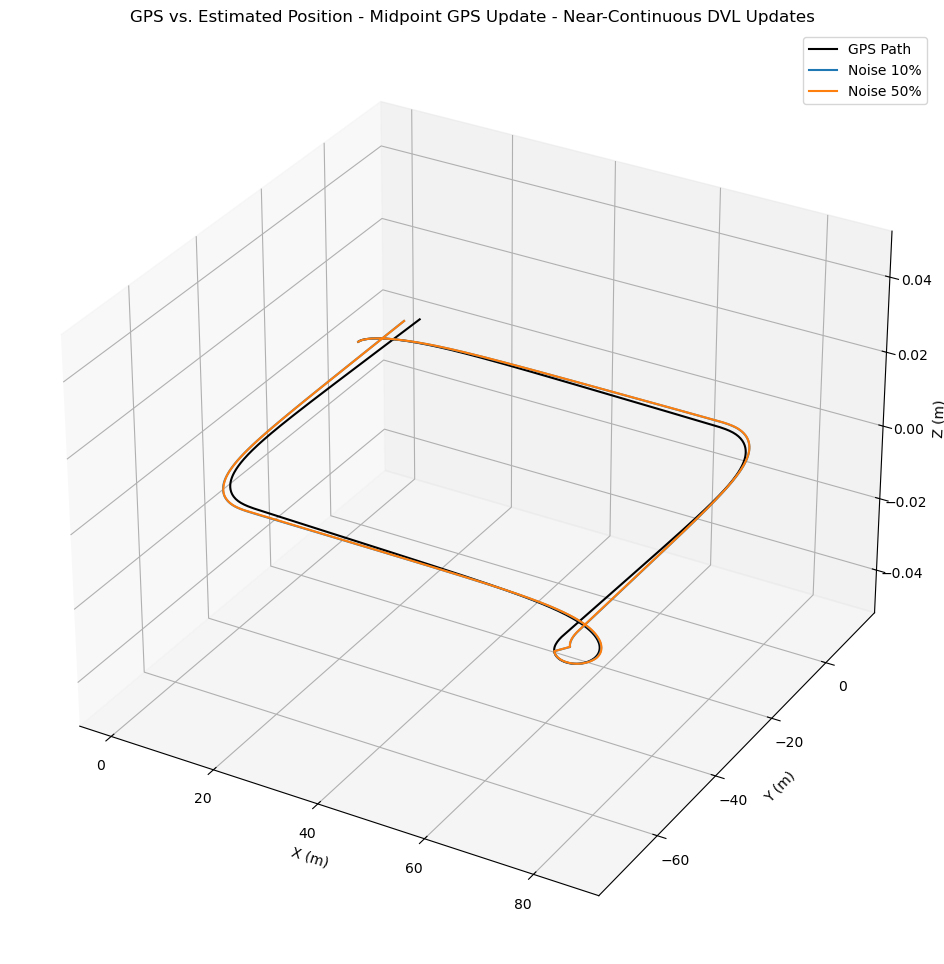

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                    1.7   
1                                 50%                                    1.7   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.55   
1                                               0.55   


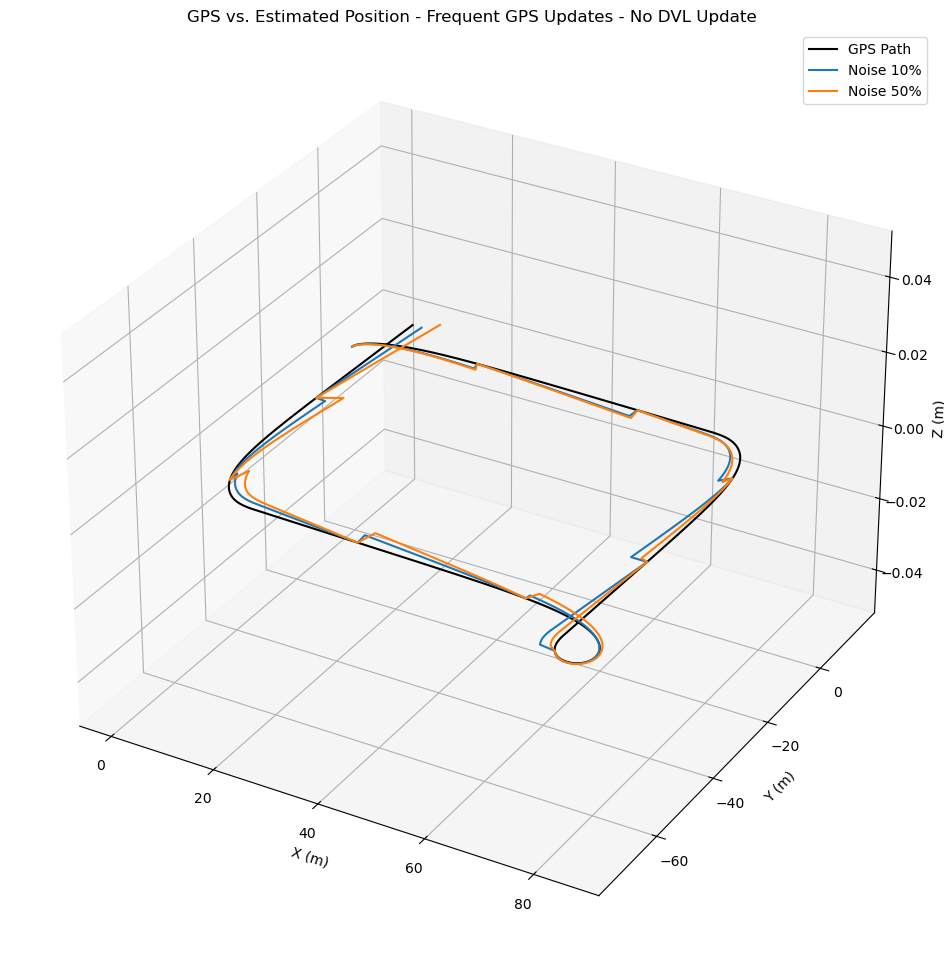

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.37   
1                                 50%                                   1.94   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.44   
1                                               0.63   


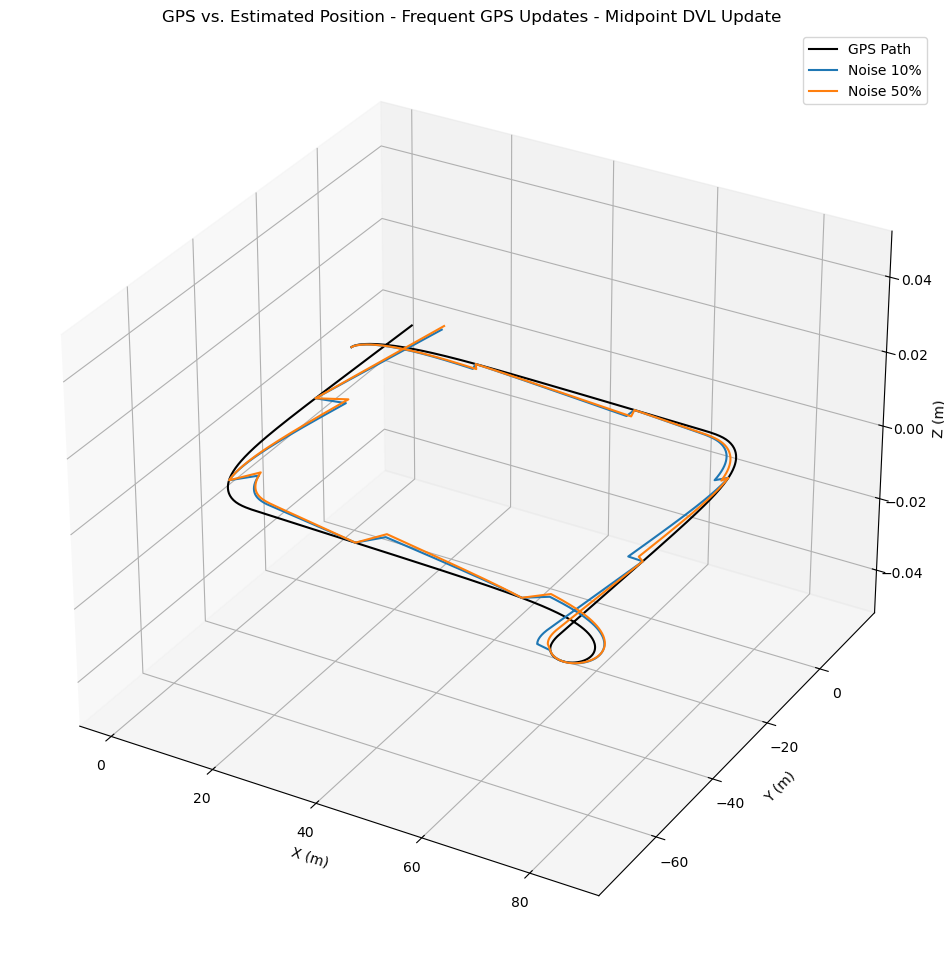

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.36   
1                                 50%                                   2.41   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.76   
1                                               0.78   


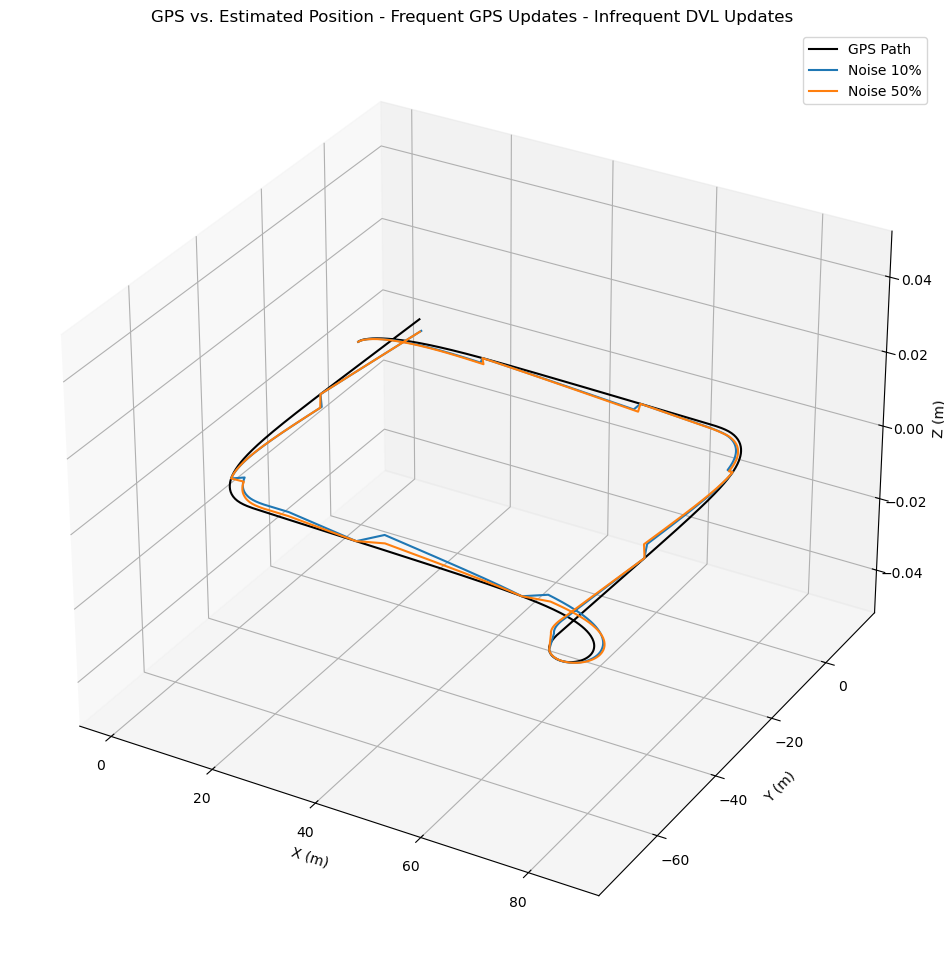

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.19   
1                                 50%                                   2.27   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.71   
1                                               0.73   


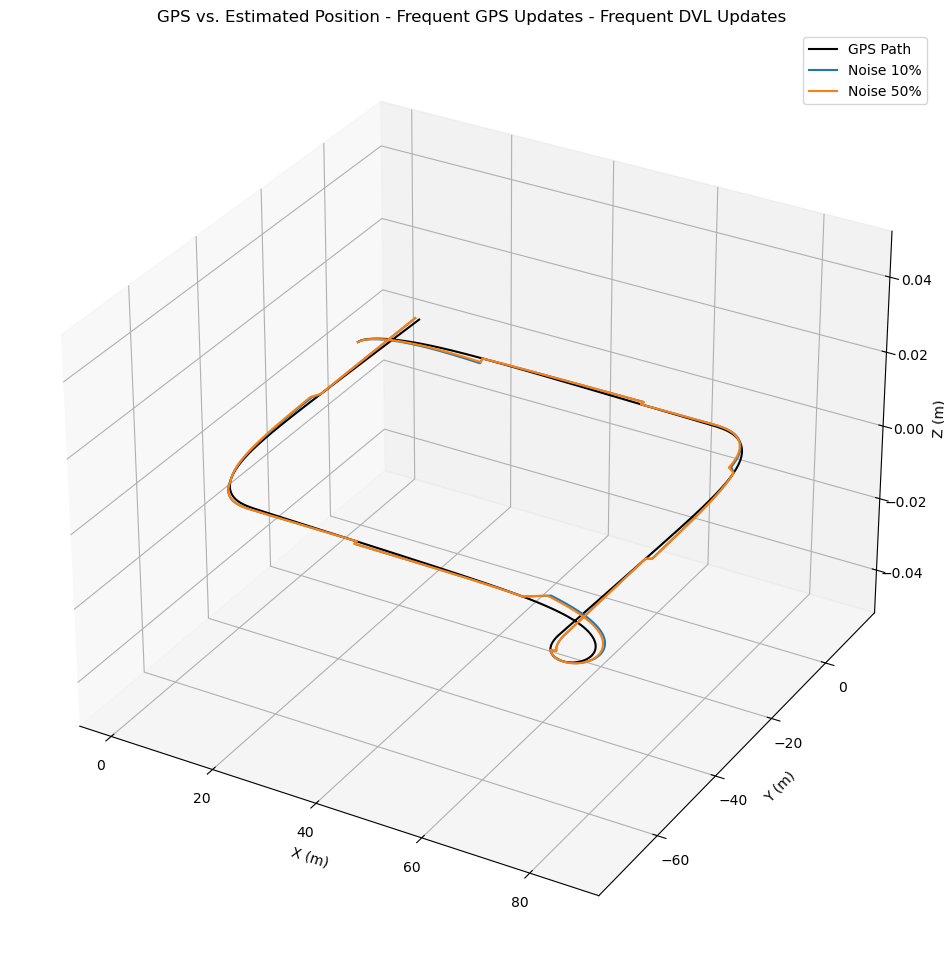

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.03   
1                                 50%                                   0.93   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.33   
1                                               0.30   


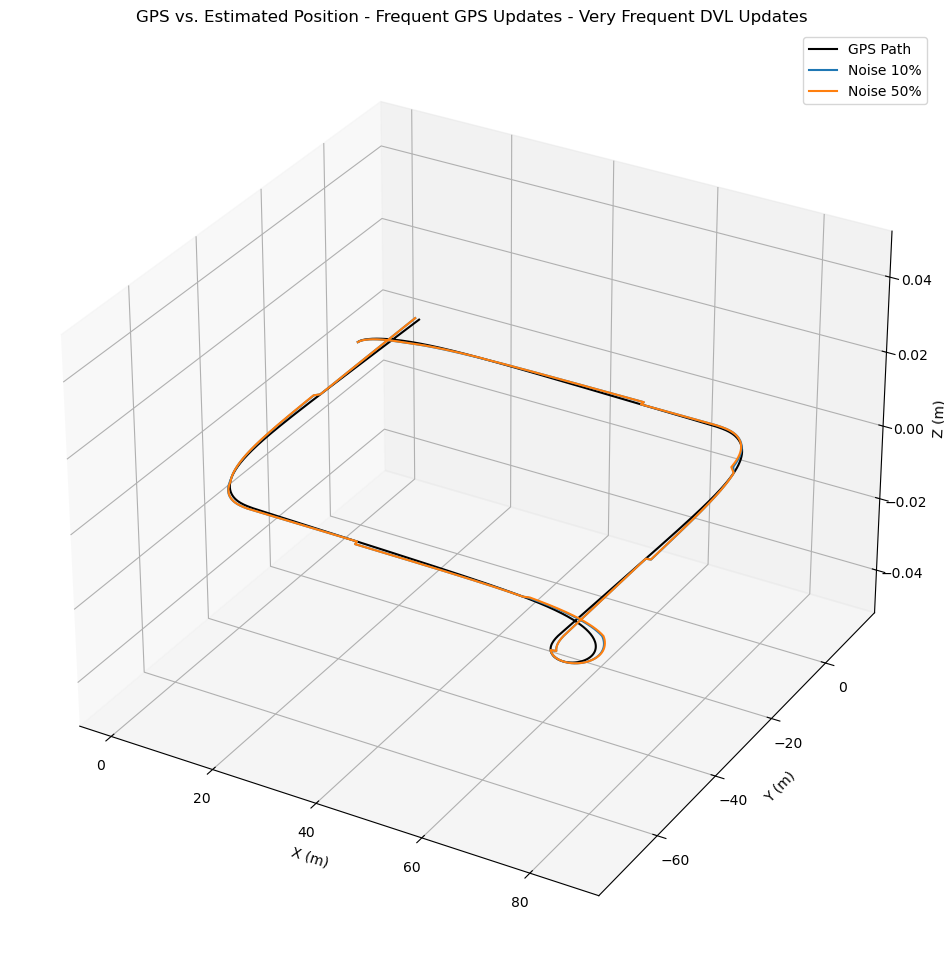

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.69   
1                                 50%                                   0.71   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.22   
1                                               0.23   


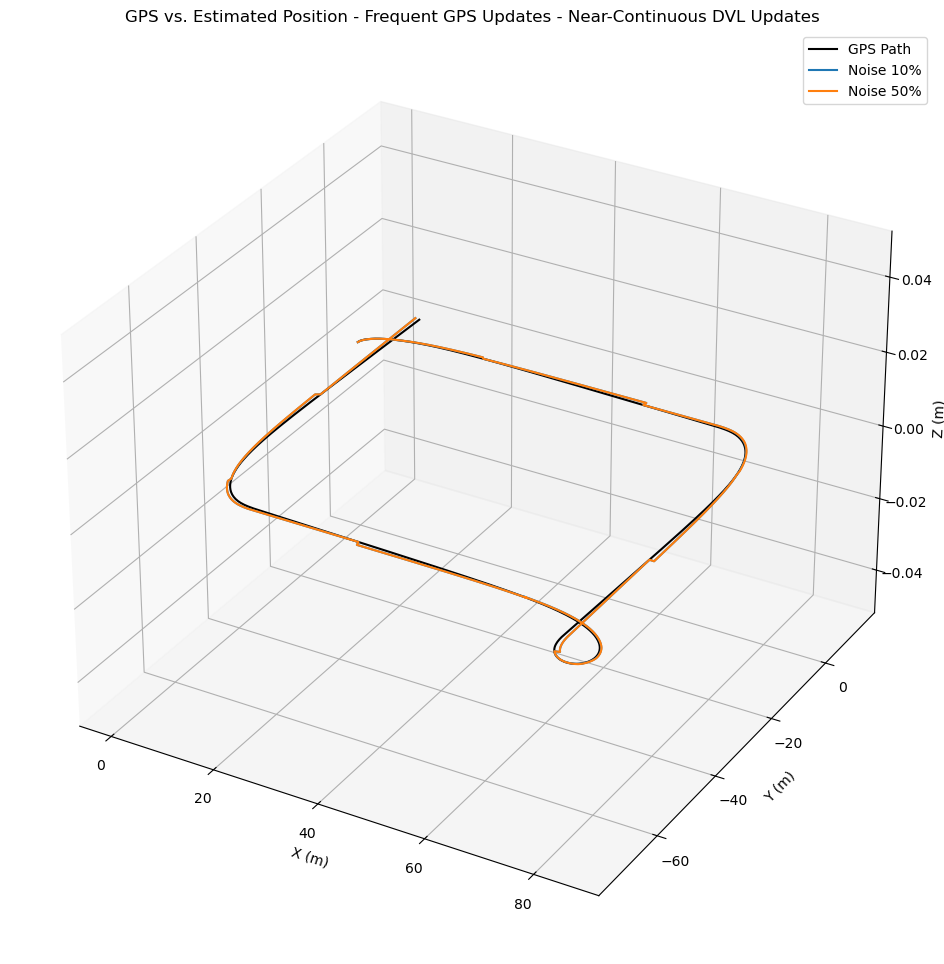

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.52   
1                                 50%                                   0.52   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.17   
1                                               0.17   


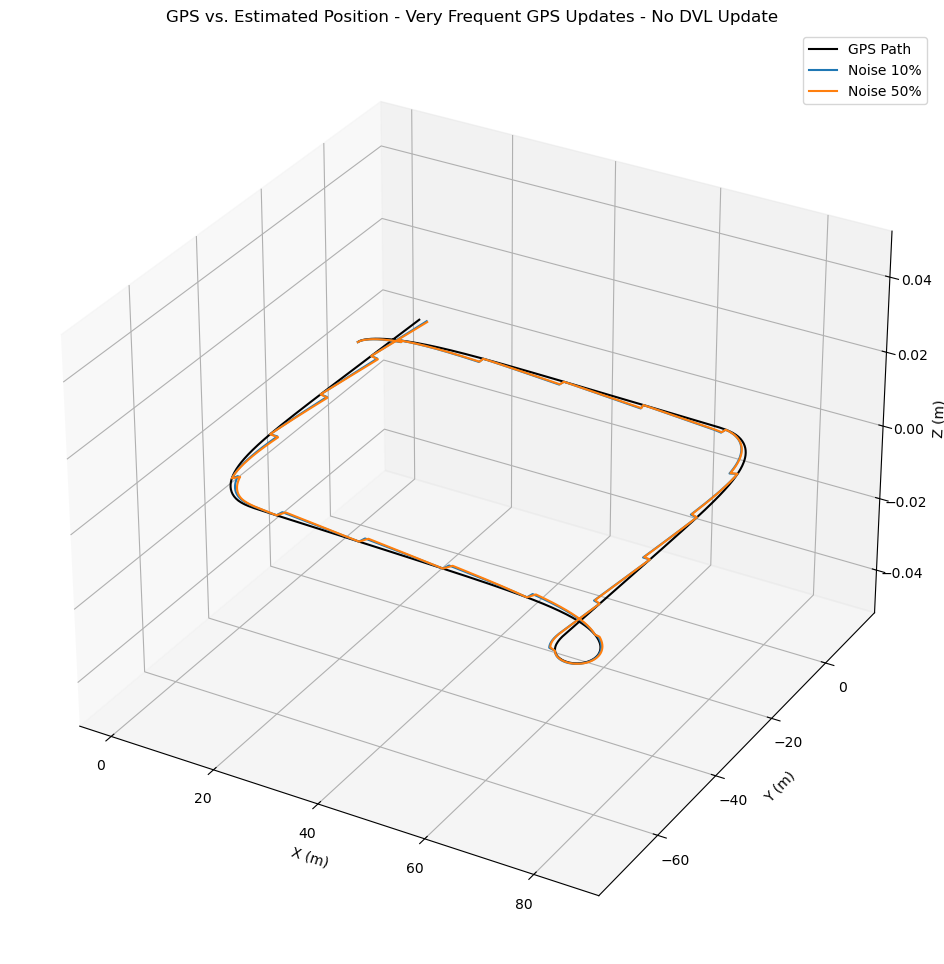

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.76   
1                                 50%                                   0.82   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.24   
1                                               0.27   


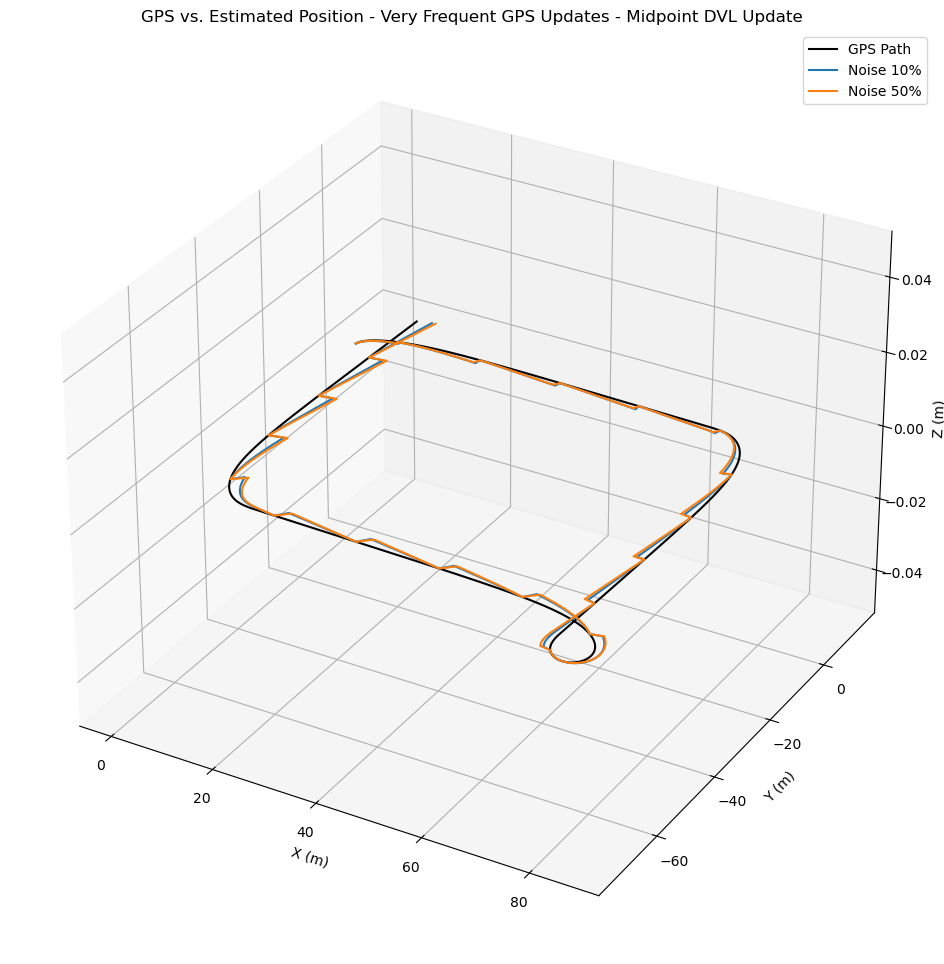

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.17   
1                                 50%                                   1.43   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.38   
1                                               0.46   


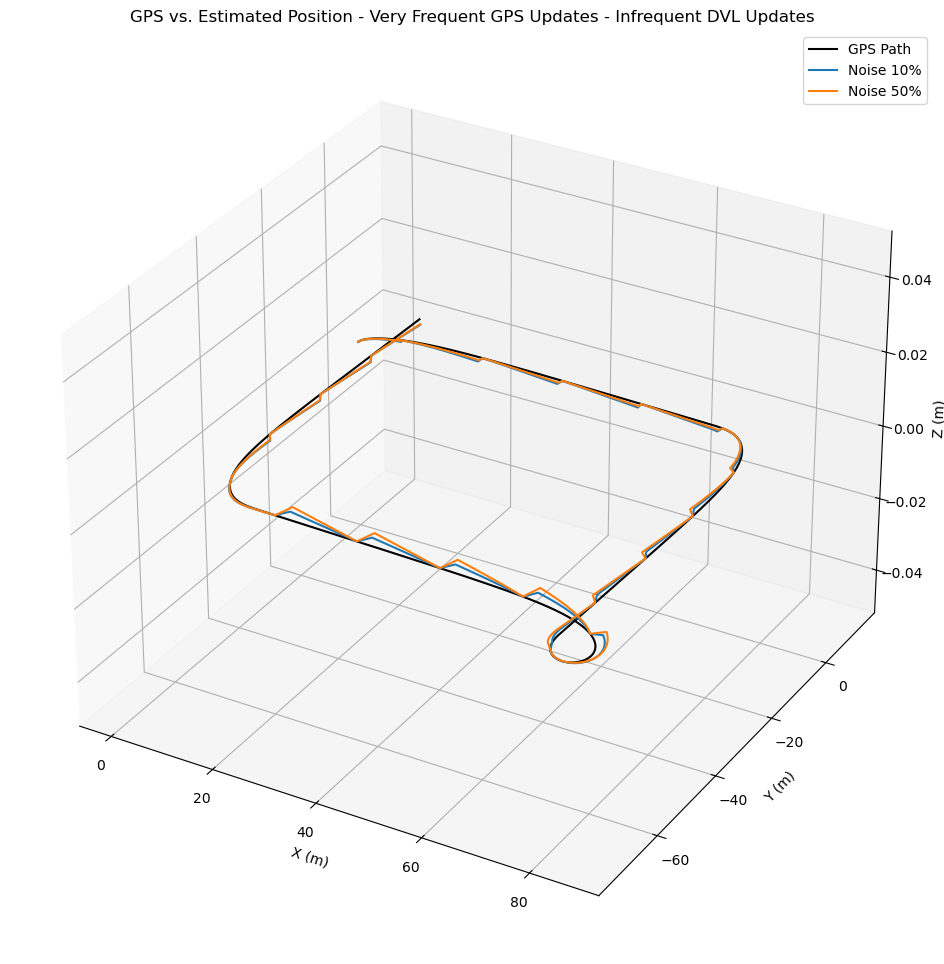

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.19   
1                                 50%                                   1.33   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.38   
1                                               0.43   


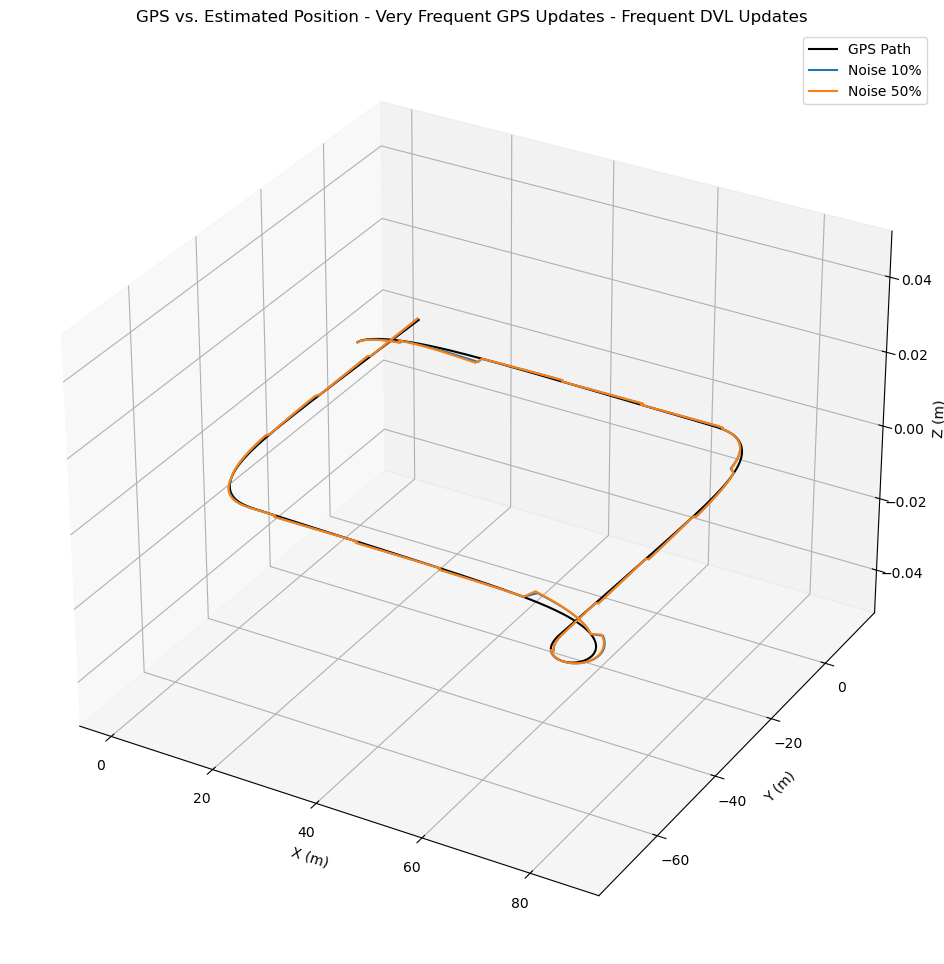

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.57   
1                                 50%                                   0.59   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.18   
1                                               0.19   


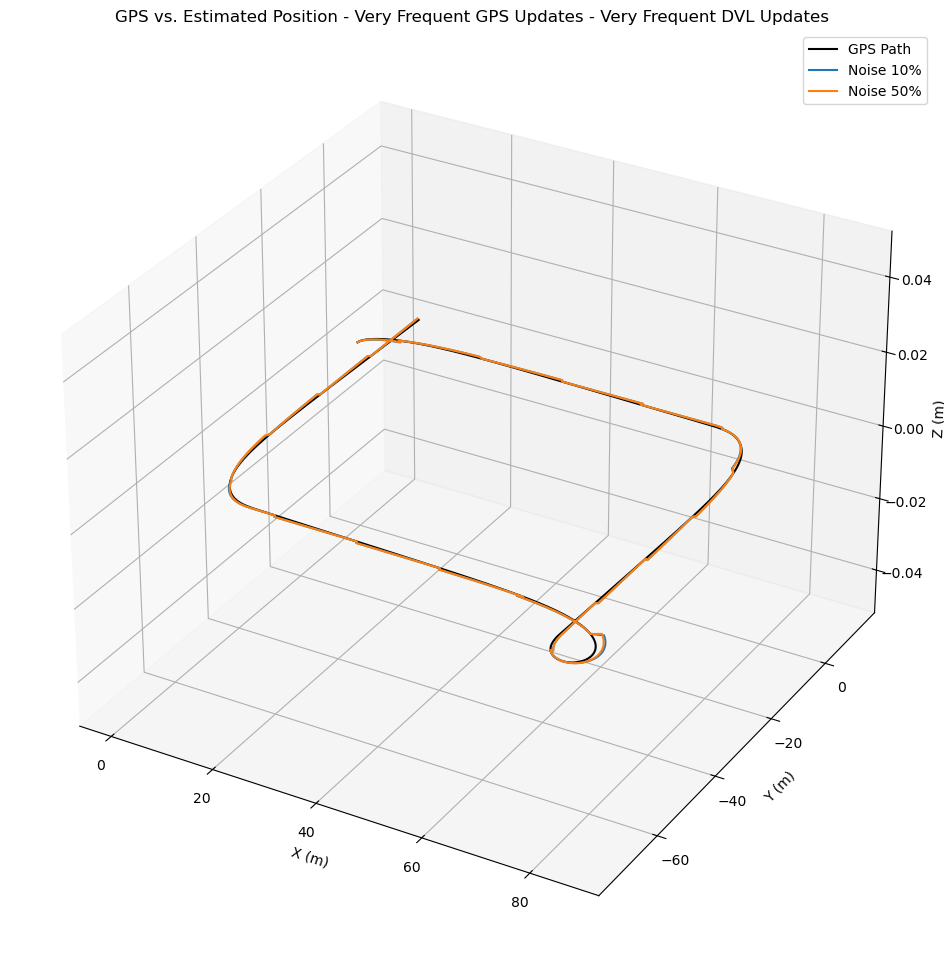

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.45   
1                                 50%                                   0.44   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.15   
1                                               0.14   


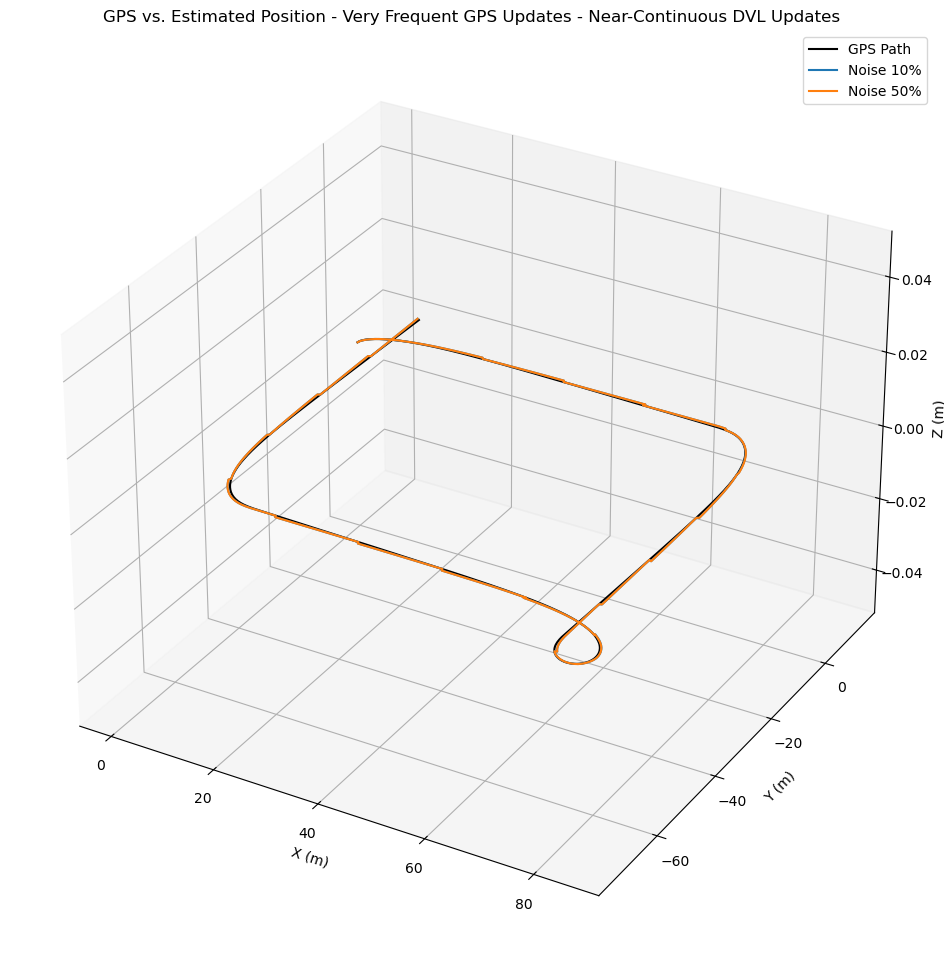

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.31   
1                                 50%                                   0.31   

   Average RMSE: Normalized per distance traveled (%)  
0                                                0.1   
1                                                0.1   


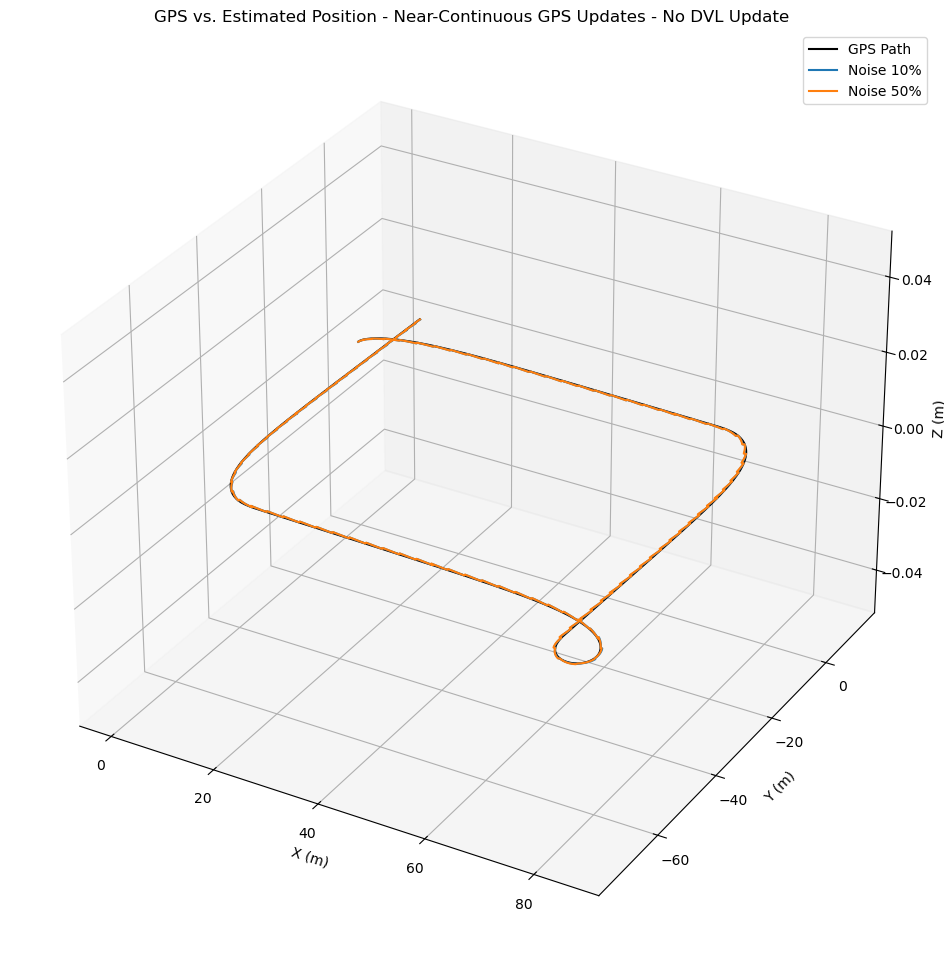

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.21   
1                                 50%                                   0.23   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.07   
1                                               0.07   


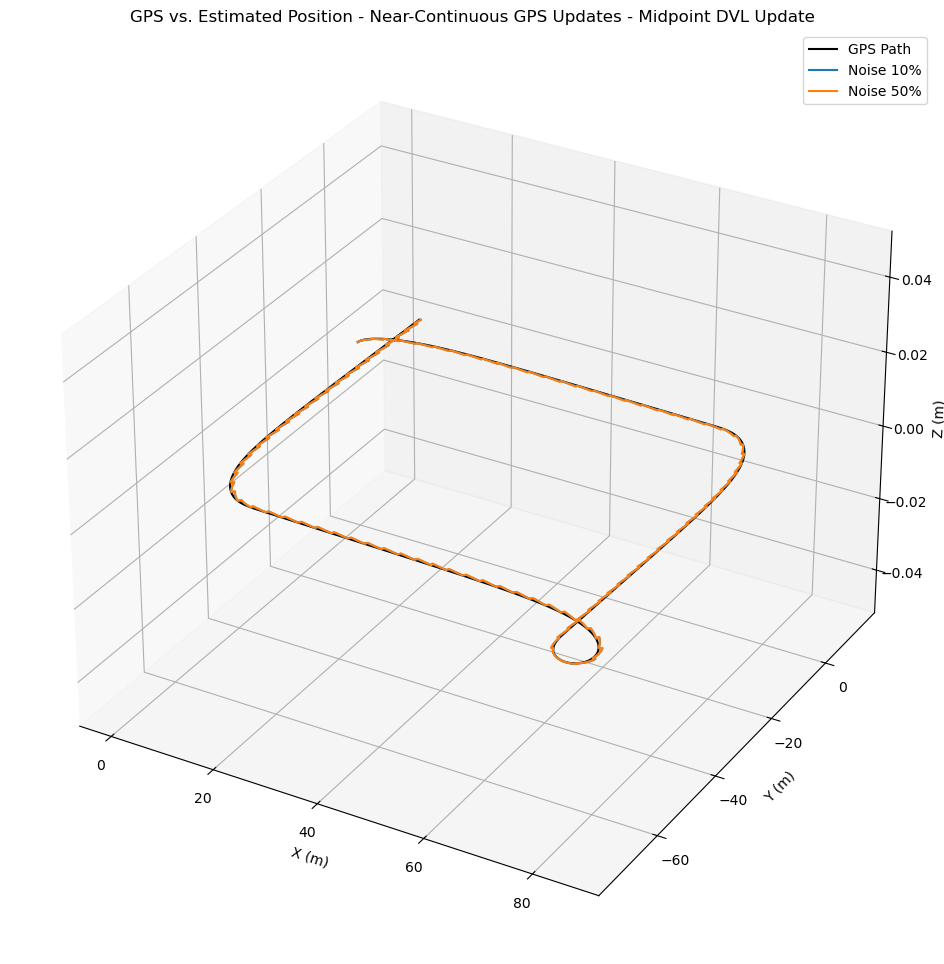

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.30   
1                                 50%                                   0.33   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.10   
1                                               0.11   


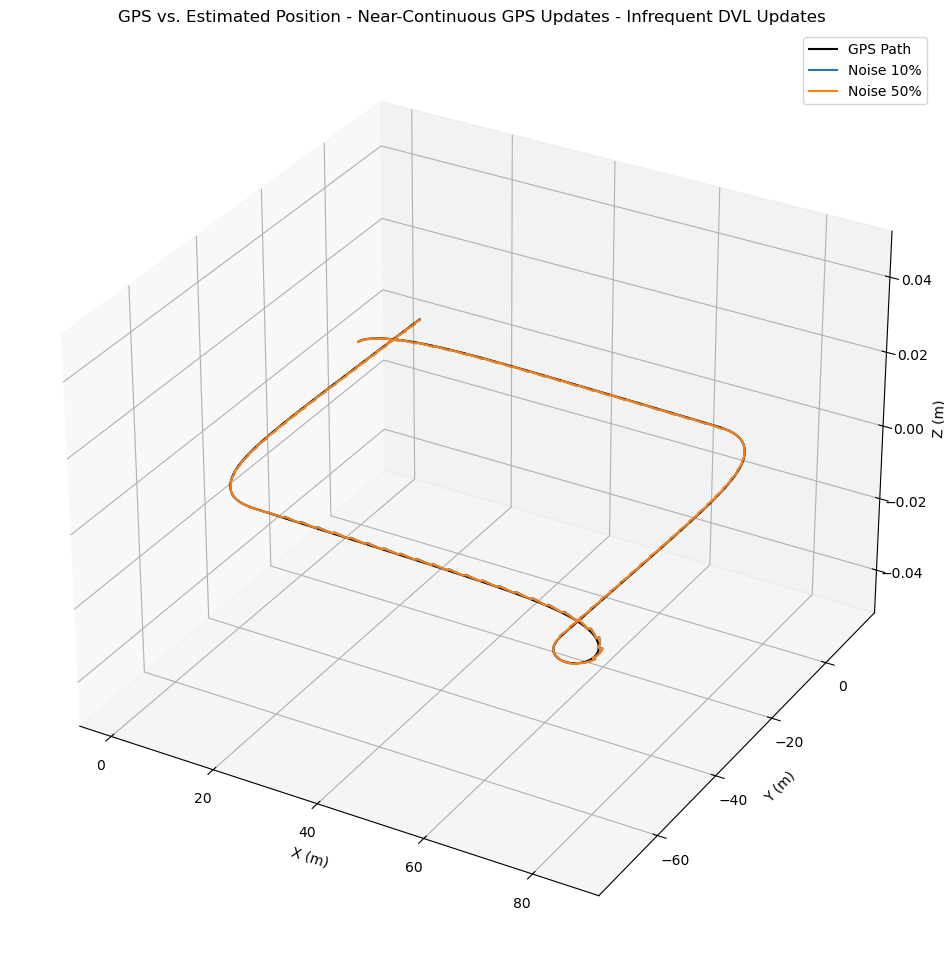

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.28   
1                                 50%                                   0.27   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.09   
1                                               0.09   


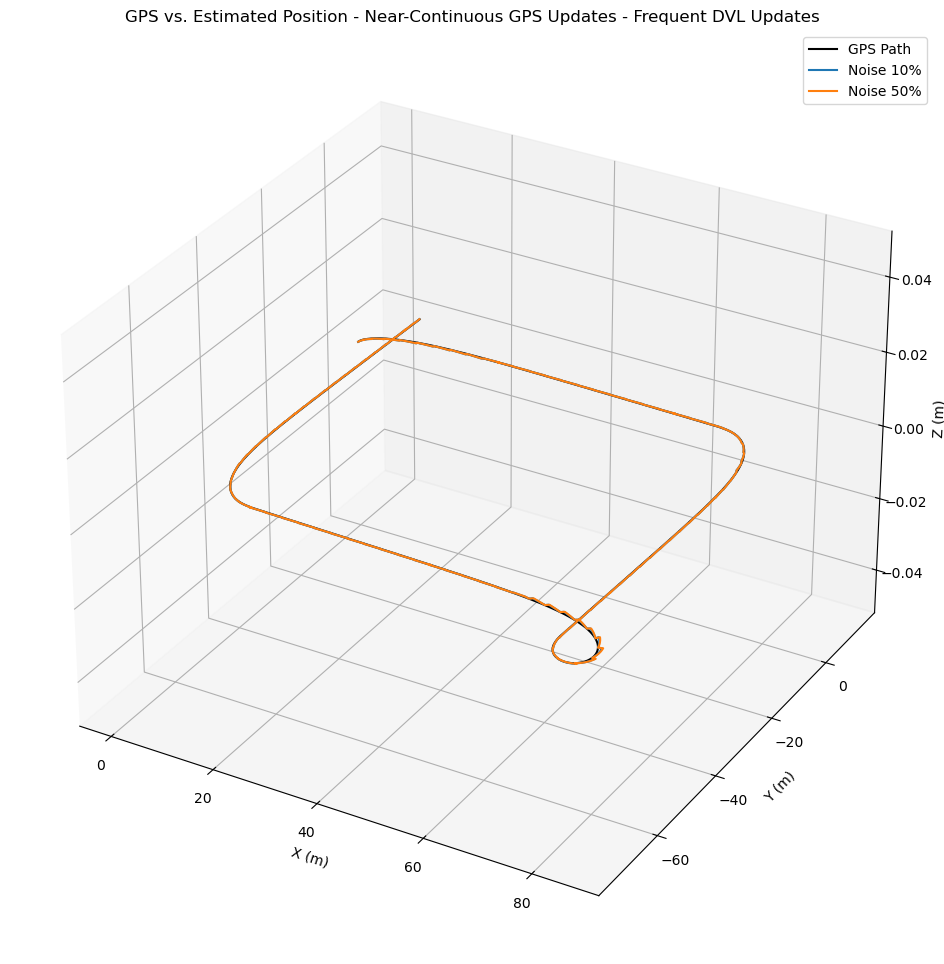

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.21   
1                                 50%                                   0.22   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.07   
1                                               0.07   


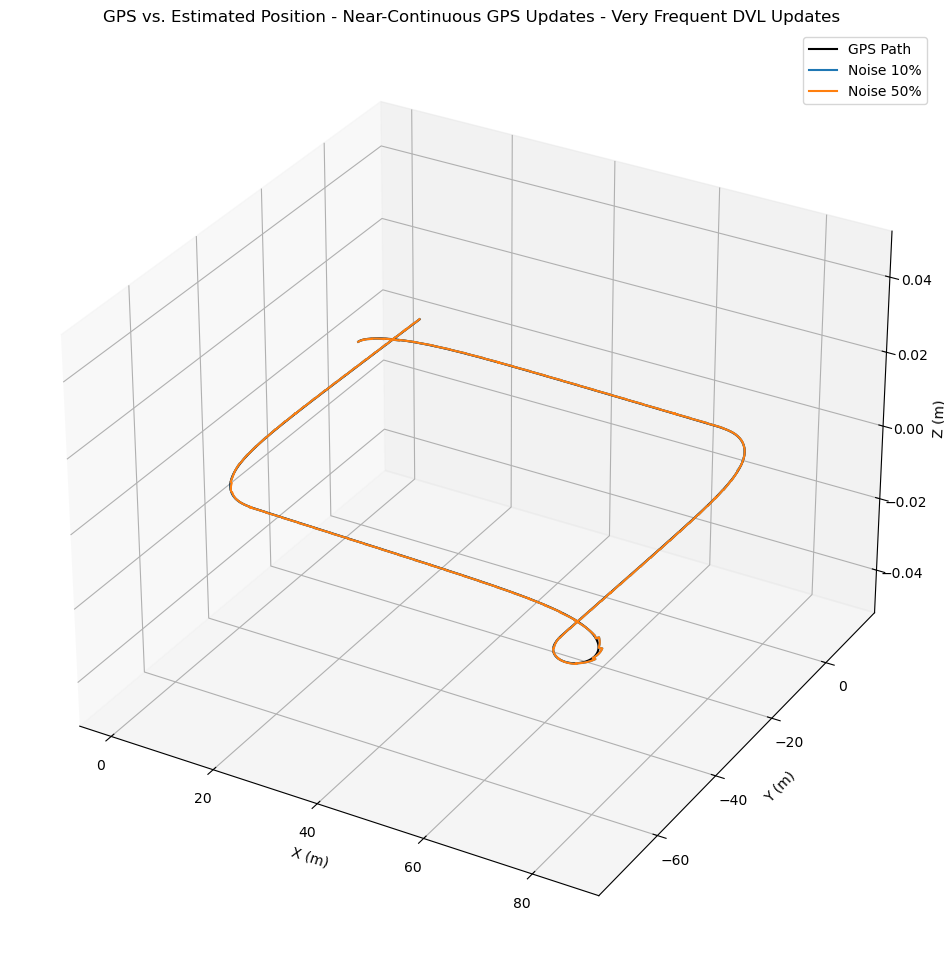

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.19   
1                                 50%                                   0.19   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.06   
1                                               0.06   


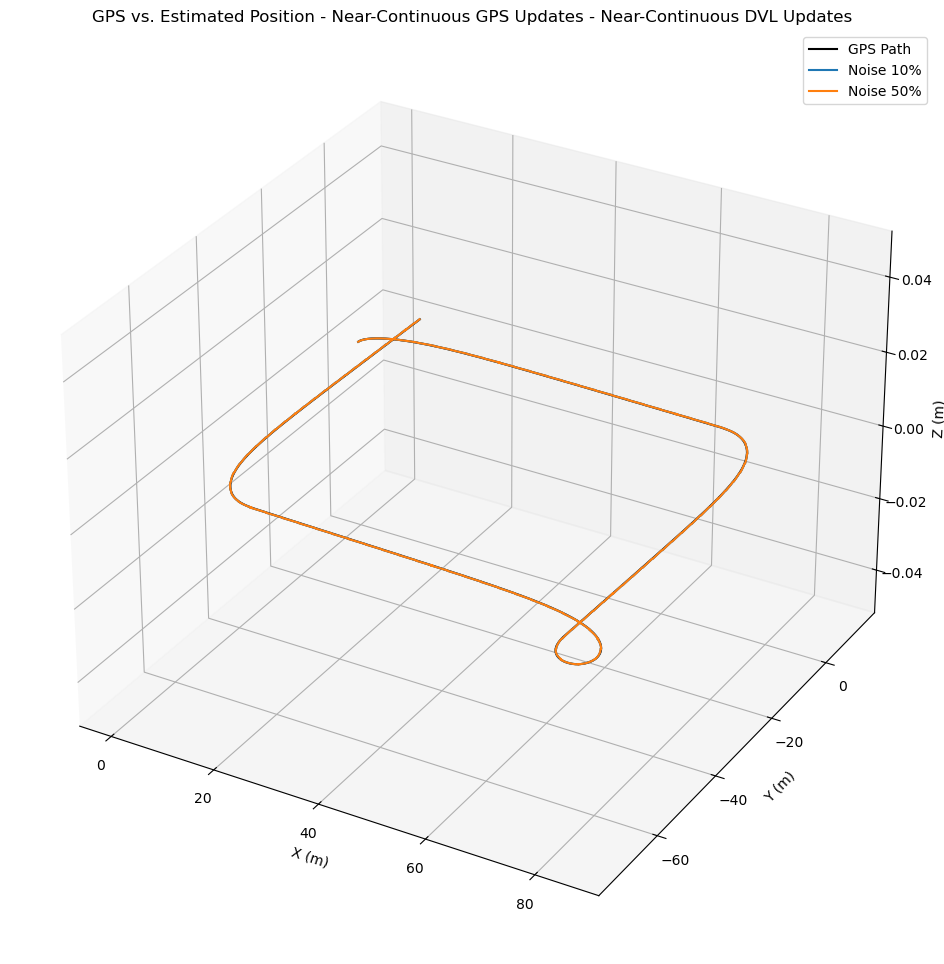

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.17   
1                                 50%                                   0.17   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.05   
1                                               0.05   


In [13]:
# Read Data
accel_data, gps_time_data, gps_visibility_data, gps_data, gyro_data, mag_data, time_data = read_data()
delta_t=0.01

# Specify parameters
f_dvl_values = [100,50,25,10,5,1]
noise_level_values = [10,50]
f_gps_values = [100,50,10,5,1]

# Main Loop
for f_gps in f_gps_values:
    for f_dvl in f_dvl_values:
        
        imu_positions = {}
        rmse_results = pd.DataFrame(columns=["Noise (% amplitude of Acceleration)", " Average RMSE: Distance from path (m)", "Average RMSE: Normalized per distance traveled (%)"])
        
        for noise_level in noise_level_values:
            # Calculate noise amplitude as a percentage of the acceleration value
            noise_amplitude_x = noise_level / 100 * accel_data['accel_x (m/s^2)']
            noise_amplitude_y = noise_level / 100 * accel_data['accel_y (m/s^2)']
            noise_amplitude_z = noise_level / 100 * accel_data['accel_z (m/s^2)']
        
            # Generate random noise within the range and add it to the acceleration data
            noisy_accel_x = accel_data['accel_x (m/s^2)'] + np.random.uniform(-noise_amplitude_x, noise_amplitude_x)
            noisy_accel_y = accel_data['accel_y (m/s^2)'] + np.random.uniform(-noise_amplitude_y, noise_amplitude_y)
            noisy_accel_z = accel_data['accel_z (m/s^2)'] + np.random.uniform(-noise_amplitude_z, noise_amplitude_z)
        
            # Combine noisy acceleration into a single numpy array
            noisy_accel = np.column_stack((noisy_accel_x, noisy_accel_y, noisy_accel_z))
        
            # Run Kalman filter and transform acceleration to NED frame
            filtered_accel_ned = run_kalman_filter_with_transformation(noisy_accel, mag_data, delta_t, var=noise_level**2)
        
            # Calculate positions with GPS update
            imu_positions_x, imu_positions_y = calculate_position_with_gps_update(filtered_accel_ned, gps_data, time_data['time (sec)'], delta_t, f_gps, f_dvl)
        
            #Calculate RMSE
            rmse, normalized_rmse = calculate_rmse(imu_positions_x, imu_positions_y, time_data['time (sec)'], gps_data, gps_time_data['gps_time (sec)'])
            
            imu_positions[f"Noise {noise_level}%"] = (imu_positions_x, imu_positions_y)
        
            rmse_results.loc[len(rmse_results)] = [f"{noise_level}%", rmse, normalized_rmse]

            plot_label = f"Noise {noise_level}% Acceleration Amplitude, GPS Update {f_gps}%, DVL Update {f_dvl}%"
            
        plot_data(imu_positions, gps_data, plot_label, f_gps, f_dvl)      
        print(rmse_results)